# Projeto Análise de Preços de Imóveis de São Paulo

O mercado imobiliário de São Paulo é um dos mais complexos e voláteis da América Latina, onde a precificação de um imóvel raramente segue uma lógica linear. Este projeto de Ciência de Dados tem como objetivo desmistificar a formação de preços na capital paulista, utilizando dados reais de ofertas de apartamentos recolhidos em novembro de 2024.

Através de técnicas de limpeza de dados, engenharia de atributos (feature engineering) e análise exploratória, transformamos milhares de linhas de dados brutos em insights acionáveis. O estudo foca-se não apenas no valor final do imóvel, mas isola variáveis críticas como o preço por metro quadrado, a influência da localização geográfica (latitude/longitude) e o impacto de amenidades, como lugares de garagem, na valorização do património.

Principais Objetivos:

Mapeamento de Valor: Identificar as zonas mais valorizadas e as oportunidades ocultas (bairros subvalorizados).

Fatores de Influência: Quantificar o impacto de características físicas (área, quartos) versus localização.

Deteção de Anomalias: Encontrar imóveis com preços desajustados da realidade do mercado (outliers).

Ferramentas Utilizadas: Python, Pandas, Matplotlib/Seaborn e GeoPandas.

Os Dados foram tirados deste dataset público do Kaggle https://www.kaggle.com/datasets/marcelobatalhah/discover-so-paulo-apartment-prices-insights

1. Importação e Carregamento dos Dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Carregar os arquivos
df_base = pd.read_csv('SaoPaulo_OnlyAppartments.csv')
df_geo = pd.read_csv('SaoPaulo_OnlyAppartments_2024-11-25.csv')

# Concatenar e remover duplicatas (priorizando o arquivo mais recente com geo-localização)
df = pd.concat([df_geo, df_base]).drop_duplicates(subset='ID', keep='first')

# Converter datas
df['created_date'] = pd.to_datetime(df['created_date'])
df['extract_date'] = pd.to_datetime(df['extract_date'])

print(f"Total de imóveis únicos analisados: {df.shape[0]}")
df.head()

Total de imóveis únicos analisados: 44957


,ID,created_date,Price,below_price,Area,Adress,Bedrooms,Bathrooms,Parking_Spaces,extract_date,Latitude,Longitude
0,2621660830,2021-02-08 20:20:19+00:00,539000,False,43,"Rua Coronel Luís Barroso 582, Santo Amaro - Sã...",1,1,1,2024-11-25,-23.647002,-46.704905
1,2751807421,2018-03-27 15:40:41+00:00,1649980,False,45,"Rua Diogo Jácome 955, Vila Nova Conceição - Sã...",1,1,1,2024-11-25,NaN,NaN
2,2735056019,2020-07-22 21:05:19+00:00,1149000,False,57,"Rua Fernão Dias 323, Pinheiros - São Paulo/SP",1,1,1,2024-11-25,-23.564136,-46.695173
3,2758506978,2024-11-12 13:41:55+00:00,255000,False,55,"Avenida Paes de Barros 411, Mooca - São Paulo/SP",1,1,1,2024-11-25,-23.559150,-46.599869
4,2556833428,2021-10-29 00:18:35+00:00,232800,False,35,"Rua Professor Artur Primavesi 154, Parque Bris...",1,1,1,2024-11-25,NaN,NaN


2. Limpeza dos Dados

In [2]:
# 1. Extração do Bairro (Regex para pegar texto entre a primeira vírgula e o hífen)
# Exemplo: "Rua X, Vila Mariana - São Paulo" -> "Vila Mariana"
df['Neighborhood'] = df['Adress'].str.extract(r',\s(.*?)\s-')[0]

# 2. Limpeza de Bairros (Opcional: padronizar nomes comuns se necessário)
# Às vezes o CEP aparece no lugar do bairro, filtrar esses casos pode ser útil
df = df[~df['Neighborhood'].str.contains(r'\d', na=False)] 

# 3. Criar Feature: Preço por Metro Quadrado
df['Price_m2'] = df['Price'] / df['Area']

# Filtrar outliers extremos (opcional, mas recomendado para análises de média)
# Ex: Remover imóveis com preço/m2 menor que R$1.000 (provável erro) ou maior que R$100.000
df = df[(df['Price_m2'] > 1000) & (df['Price_m2'] < 100000)]

3. Análise de Dados e Insights


In [3]:
# Agrupar por bairro e calcular média do preço/m2 e contagem de imóveis
bairros_stats = df.groupby('Neighborhood').agg({
    'Price_m2': 'mean',
    'Price': 'mean',
    'ID': 'count'
}).rename(columns={'ID': 'Qtd_Imoveis'})

# Filtrar apenas bairros com relevância estatística (ex: > 10 imóveis)
bairros_relevantes = bairros_stats[bairros_stats['Qtd_Imoveis'] > 10]

# Top 10 Bairros Mais Caros
top_10_caros = bairros_relevantes.sort_values('Price_m2', ascending=False).head(10)
print("Top 10 Bairros Mais Caros (R$/m²):")
print(top_10_caros[['Price_m2']])

Top 10 Bairros Mais Caros (R$/m²):
                                    Price_m2
Neighborhood                                
Ibirapuera                      42220.401069
Jardim Panorama                 38233.476376
Jardim Panorama (Zona Oeste)    35173.777401
Jardim Paulistano               30492.158749
Cidade Jardim                   28292.667547
Jardim América                  27838.513240
Jardim Europa                   27774.413981
Jardim Paulistano (Zona Oeste)  27658.229052
Vila Nova Conceição             25956.964459
Chácara Itaim                   23839.670364


Correlação entre variáveis

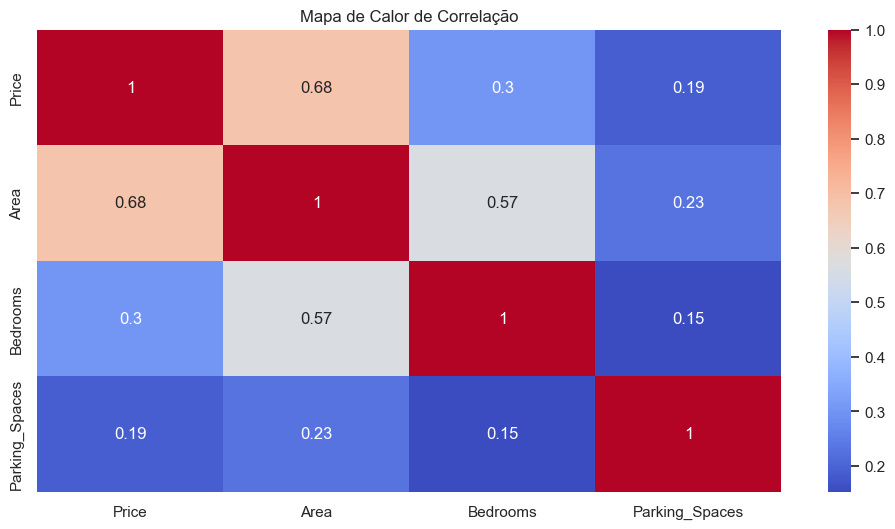

In [4]:
# Correlação
correlacao = df[['Price', 'Area', 'Bedrooms', 'Parking_Spaces']].corr()
sns.heatmap(correlacao, annot=True, cmap='coolwarm')
plt.title("Mapa de Calor de Correlação")
plt.show()

In [5]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# 1. Carregar os dados (usando o arquivo que tem coordenadas)
df_geo = pd.read_csv('SaoPaulo_OnlyAppartments_2024-11-25.csv')

# 2. Limpeza básica: remover linhas sem coordenadas ou sem preço
df_mapa = df_geo.dropna(subset=['Latitude', 'Longitude', 'Price'])

# 3. Criar uma coluna de peso (Preço por m2 é melhor para o mapa de calor)
df_mapa['Price_m2'] = df_mapa['Price'] / df_mapa['Area']

# 4. Configurar o mapa centralizado em São Paulo
m = folium.Map(location=[-23.5505, -46.6333], zoom_start=12, tiles='CartoDB positron')

# 5. Preparar os dados para o HeatMap: [[lat, lon, weight], ...]
data = df_mapa[['Latitude', 'Longitude', 'Price_m2']].values.tolist()

# 6. Adicionar a camada de calor
HeatMap(data, radius=15, blur=20, max_zoom=12).add_to(m)

# Salvar e exibir
m.save('mapa_precos_sp.html')
m

C:\Users\Samantha\AppData\Local\Temp\ipykernel_1612\1828408057.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mapa['Price_m2'] = df_mapa['Price'] / df_mapa['Area']
